  posted_date  job_postings_count
0      2023Q3                  30
1      2023Q4                 241
2      2024Q1                 262
3      2024Q2                 213
4      2024Q3                 269
5      2024Q4                 262
6      2025Q1                 267
7      2025Q2                 234
8      2025Q3                 222


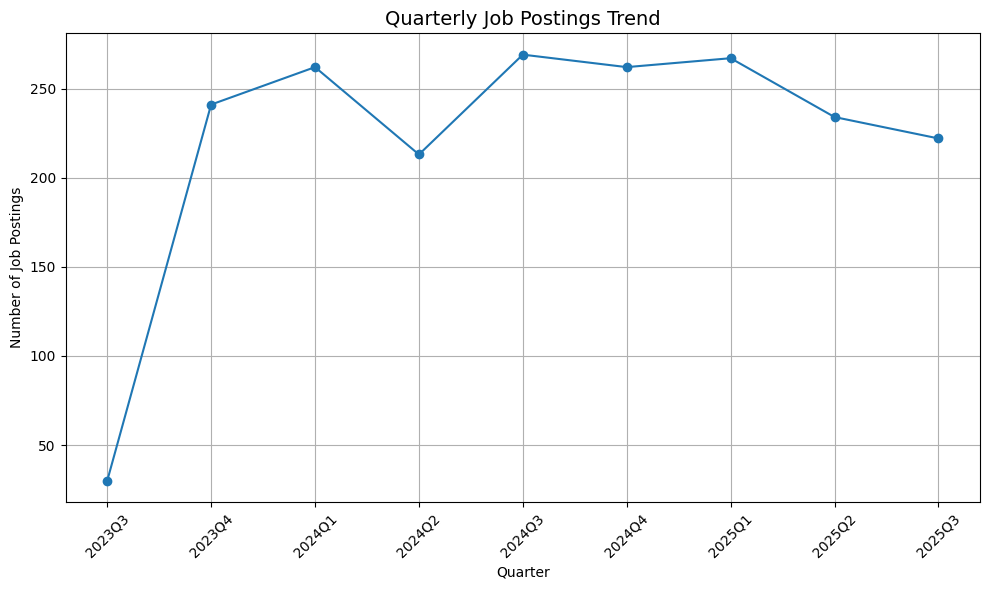

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Create output directory if it doesn't exist
output_dir = "../outputs/Member4_figure"
os.makedirs(output_dir, exist_ok=True)

# File path to the cleaned CSV dataset
file_path = "../dataset/ai_job_market_cleaned.csv"

# Read the CSV file
data = pd.read_csv(file_path)

# Convert the 'posted_date' column to datetime format
# errors='coerce' will replace invalid parsing with NaT (missing value)
data['posted_date'] = pd.to_datetime(data['posted_date'], errors='coerce')

# Group the data by quarter (Q) based on 'posted_date'
# Count the number of job postings in each quarter
quarterly_counts = (
    data.groupby(data['posted_date'].dt.to_period('Q'))
    .size()
    .reset_index(name='job_postings_count')
)

# Convert the 'posted_date' period type back to string for plotting
quarterly_counts['posted_date'] = quarterly_counts['posted_date'].astype(str)

# Print the quarterly job posting counts
print(quarterly_counts)

# Plot the trend of job postings per quarter
plt.figure(figsize=(10, 6))
plt.plot(
    quarterly_counts['posted_date'], 
    quarterly_counts['job_postings_count'], 
    marker='o', linestyle='-'
)
plt.title("Quarterly Job Postings Trend", fontsize=14)  # Title of the chart
plt.xlabel("Quarter")  # X-axis label
plt.ylabel("Number of Job Postings")  # Y-axis label
plt.grid(True)  # Add grid lines for better readability
plt.xticks(rotation=45)  # Rotate x-axis labels for better display
plt.tight_layout()  # Adjust layout to prevent overlap
plt.savefig(os.path.join(output_dir, "quarterly_job_postings_trend.png"), dpi=300, bbox_inches='tight')
plt.close()
print(f"Saved: {os.path.join(output_dir, 'quarterly_job_postings_trend.png')}")


[Job Title Trend]
job_title  AI Product Manager  AI Researcher  Computer Vision Engineer  \
period                                                                   
2023Q3                      6              3                         4   
2023Q4                     30             31                        34   
2024Q1                     32             30                        37   
2024Q2                     26             26                        21   
2024Q3                     41             31                        27   
2024Q4                     31             26                        22   
2025Q1                     34             32                        25   
2025Q2                     28             27                        37   
2025Q3                     30             31                        23   

job_title  Data Analyst  Data Scientist  ML Engineer  NLP Engineer  \
period                                                               
2023Q3                2   

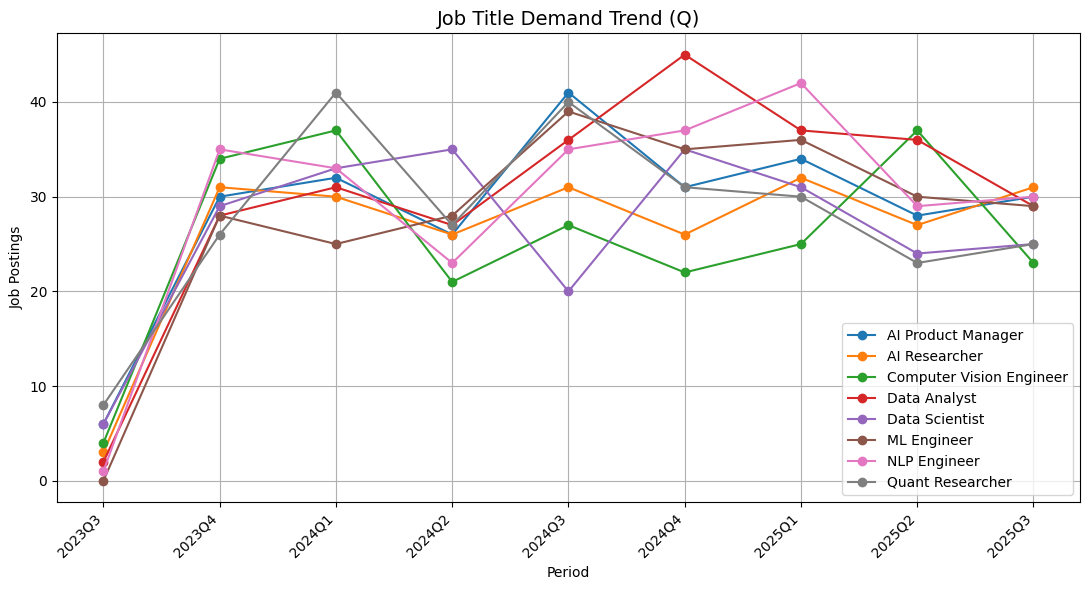


[Skill Trend]
skill   Azure  Excel  FastAPI  Hugging Face  NumPy  Pandas  \
period                                                       
2023Q3      5      6        8            11      7       3   
2023Q4     44     44       49            57     58      49   
2024Q1     59     74       52            48     55      68   
2024Q2     42     52       49            43     42      34   
2024Q3     62     46       51            63     51      60   
2024Q4     60     66       61            50     59      50   
2025Q1     61     46       57            48     54      54   
2025Q2     37     54       47            44     52      67   
2025Q3     43     44       45            44     38      42   

skill   Reinforcement Learning  TensorFlow  
period                                      
2023Q3                       5          10  
2023Q4                      46          56  
2024Q1                      59          62  
2024Q2                      43          49  
2024Q3                      60  

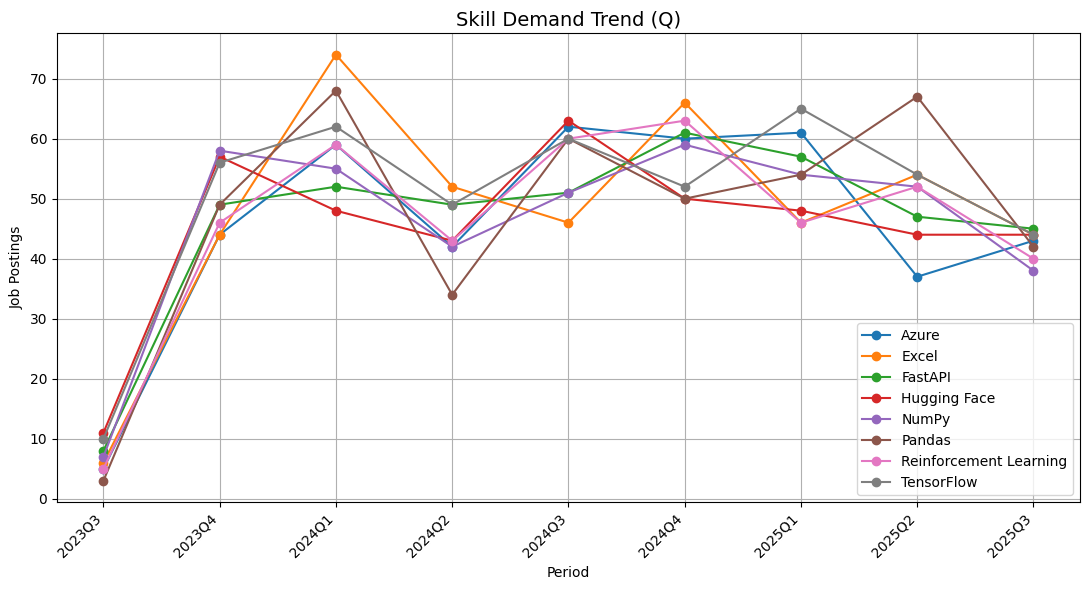

In [ ]:
from pathlib import Path

# ========== CONFIGURATION PARAMETERS ==========
FILE_PATH = "../dataset/ai_job_market_cleaned.csv"  # Path to the cleaned CSV dataset
FREQ = "Q"                                 # Frequency for aggregation: "Q" = Quarterly, "M" = Monthly
TOP_K_IF_EMPTY = 8                         # Number of top job titles/skills to select if none are specified
EXPORT_CSV = True                          # Whether to export results to CSV files
OUTPUT_DIR = "../outputs/Member4_figure"   # Directory to save figures

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

# List of target job titles to track; if empty, top N titles will be selected
TARGET_JOB_TITLES = [
  
]

# List of target skills to track; if empty, top N skills will be selected
TARGET_SKILLS = [

]

# ========== FUNCTIONS ==========

def load_data(file_path: str) -> pd.DataFrame:
    """
    Load the CSV data into a pandas DataFrame.
    Convert 'posted_date' to datetime format and drop rows with missing dates.
    """
    df = pd.read_csv(file_path)
    df["posted_date"] = pd.to_datetime(df["posted_date"], errors="coerce")
    df = df.dropna(subset=["posted_date"])
    return df

def to_period_label(s: pd.Series, freq: str) -> pd.Series:
    """
    Convert datetime series into period labels based on frequency.
    freq = "Q" -> Quarterly
    freq = "M" -> Monthly
    """
    if freq.upper() == "Q":
        return s.dt.to_period("Q").astype(str)
    elif freq.upper() == "M":
        return s.dt.to_period("M").astype(str)
    else:
        raise ValueError("FREQ must be 'M' or 'Q'")

def aggregate_job_title_trend(df: pd.DataFrame, titles: list | None, freq: str) -> pd.DataFrame:
    """
    Aggregate job posting counts over time for specified job titles.
    If titles are not provided, use the top N most frequent job titles.
    Returns a pivot table with periods as rows and job titles as columns.
    """
    if not titles:
        top_titles = df["job_title"].value_counts().head(TOP_K_IF_EMPTY).index.tolist()
    else:
        top_titles = titles

    use = df[df["job_title"].isin(top_titles)].copy()
    use["period"] = to_period_label(use["posted_date"], freq)
    grouped = (
        use.groupby(["period", "job_title"])
           .size()
           .reset_index(name="count")
           .sort_values(["period", "job_title"])
    )
    pivot = grouped.pivot(index="period", columns="job_title", values="count").fillna(0).astype(int)
    pivot = pivot.sort_index()  
    return pivot

def explode_skills_column(df: pd.DataFrame) -> pd.DataFrame:
    """
    Split the 'skills_required' column (comma-separated skills) into individual rows.
    Returns a DataFrame with one skill per row.
    """
    skills = (
        df.dropna(subset=["skills_required"])
          .assign(skill=lambda x: x["skills_required"].str.split(","))
          .explode("skill")
    )
    skills["skill"] = skills["skill"].str.strip()
    skills = skills[skills["skill"] != ""]
    return skills

def aggregate_skill_trend(df: pd.DataFrame, skills: list | None, freq: str) -> pd.DataFrame:
    """
    Aggregate job posting counts over time for specified skills.
    If skills are not provided, use the top N most frequent skills.
    Returns a pivot table with periods as rows and skills as columns.
    """
    skill_df = explode_skills_column(df)
    if not skills:
        top_skills = skill_df["skill"].value_counts().head(TOP_K_IF_EMPTY).index.tolist()
    else:
        top_skills = skills

    use = skill_df[skill_df["skill"].isin(top_skills)].copy()
    use["period"] = to_period_label(use["posted_date"], freq)
    grouped = (
        use.groupby(["period", "skill"])
           .size()
           .reset_index(name="count")
           .sort_values(["period", "skill"])
    )
    pivot = grouped.pivot(index="period", columns="skill", values="count").fillna(0).astype(int)
    pivot = pivot.sort_index()
    return pivot

def plot_lines(pivot: pd.DataFrame, title: str, filename: str, xlabel: str = "Period", ylabel: str = "Job Postings"):
    """
    Plot line charts for job title or skill trends.
    Each column in the pivot table is plotted as a separate line.
    Save the figure to the output directory.
    """
    plt.figure(figsize=(11, 6))
    for col in pivot.columns:
        plt.plot(pivot.index, pivot[col], marker="o", label=str(col))
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45, ha="right")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    save_path = os.path.join(OUTPUT_DIR, filename)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Saved: {save_path}")

def maybe_export_csv(df: pd.DataFrame, name: str, freq: str):
    """
    Export the pivot table DataFrame to a CSV file if EXPORT_CSV is True.
    The filename includes the type of trend and frequency (M/Q).
    """
    if not EXPORT_CSV:
        return
    out = Path(f"{name}_{freq}.csv")
    df.to_csv(out, encoding="utf-8-sig")
    print(f"Exported: {out}")


# ========== MAIN SCRIPT EXECUTION ==========

# Load dataset
data = load_data(FILE_PATH)

# ---- Job Title Trend ----
job_pivot = aggregate_job_title_trend(data, TARGET_JOB_TITLES, FREQ)
print("\n[Job Title Trend]")
print(job_pivot)
maybe_export_csv(job_pivot, "job_title_trend", FREQ)
plot_lines(job_pivot, title=f"Job Title Demand Trend ({FREQ})", filename="job_title_demand_trend.png")

# ---- Skill Trend ----
skill_pivot = aggregate_skill_trend(data, TARGET_SKILLS, FREQ)
print("\n[Skill Trend]")
print(skill_pivot)
maybe_export_csv(skill_pivot, "skill_trend", FREQ)
plot_lines(skill_pivot, title=f"Skill Demand Trend ({FREQ})", filename="skill_demand_trend.png")

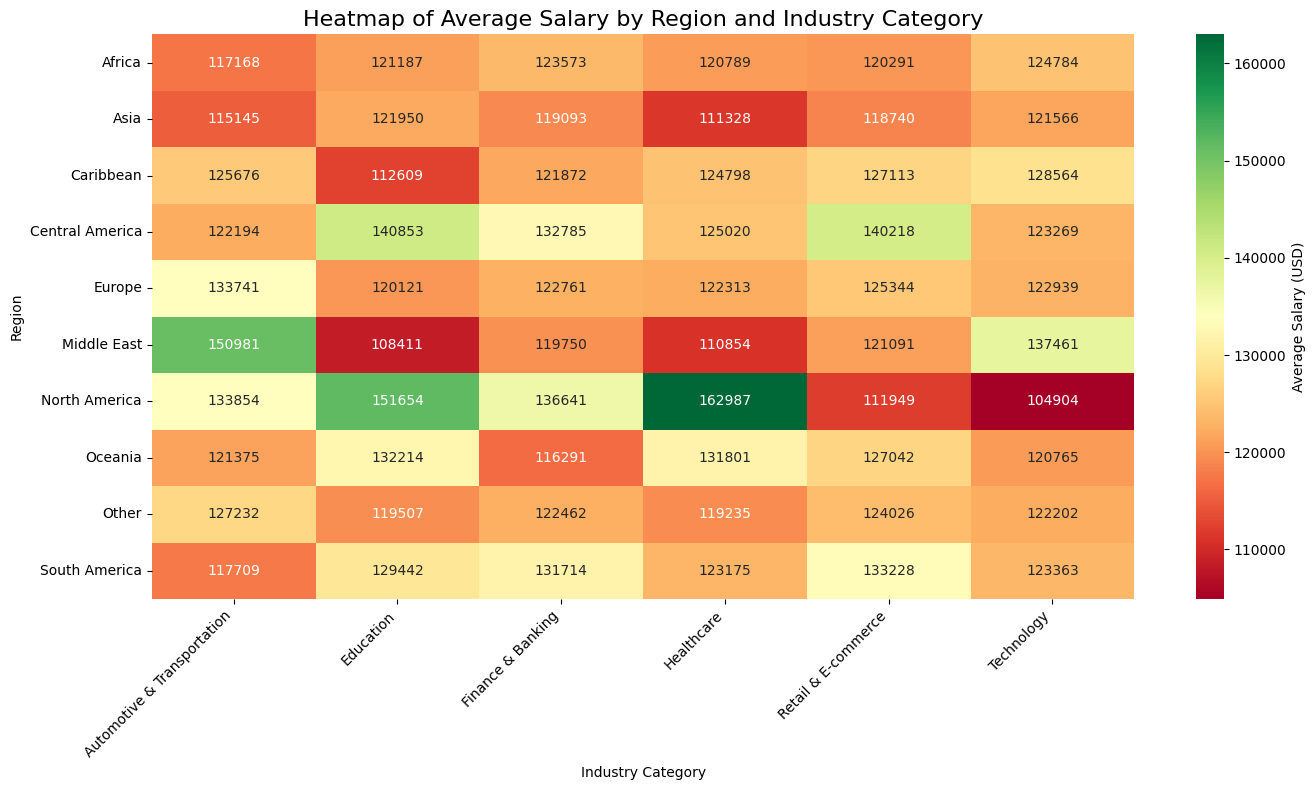

In [ ]:
import seaborn as sns

# File path to the cleaned CSV dataset
file_path = "../dataset/ai_job_market_cleaned.csv"

# Load the CSV file into a pandas DataFrame
data = pd.read_csv(file_path)

# Create a pivot table for heatmap:
# - Rows: regions
# - Columns: industry categories
# - Values: average salary (salary_avg)
# - Fill missing values with 0
heatmap_data = pd.pivot_table(
    data,
    index='region',
    columns='industry_category',
    values='salary_avg',
    aggfunc='mean',
    fill_value=0
)

# Plot heatmap of average salary by region and industry category
plt.figure(figsize=(14, 8))
sns.heatmap(
    heatmap_data,
    cmap="RdYlGn",                   # Color palette (Red-Yellow-Green for salary levels)
    annot=True,                     # Annotate cells with values
    fmt=".0f",                      # Format as integer
    cbar_kws={'label': 'Average Salary (USD)'}  # Color bar label
)
plt.title("Heatmap of Average Salary by Region and Industry Category", fontsize=16)  # Chart title
plt.xlabel("Industry Category")   # X-axis label
plt.ylabel("Region")    # Y-axis label
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent overlap
plt.savefig(os.path.join(output_dir, "salary_heatmap_by_region_industry.png"), dpi=300, bbox_inches='tight')
plt.close()
print(f"Saved: {os.path.join(output_dir, 'salary_heatmap_by_region_industry.png')}")

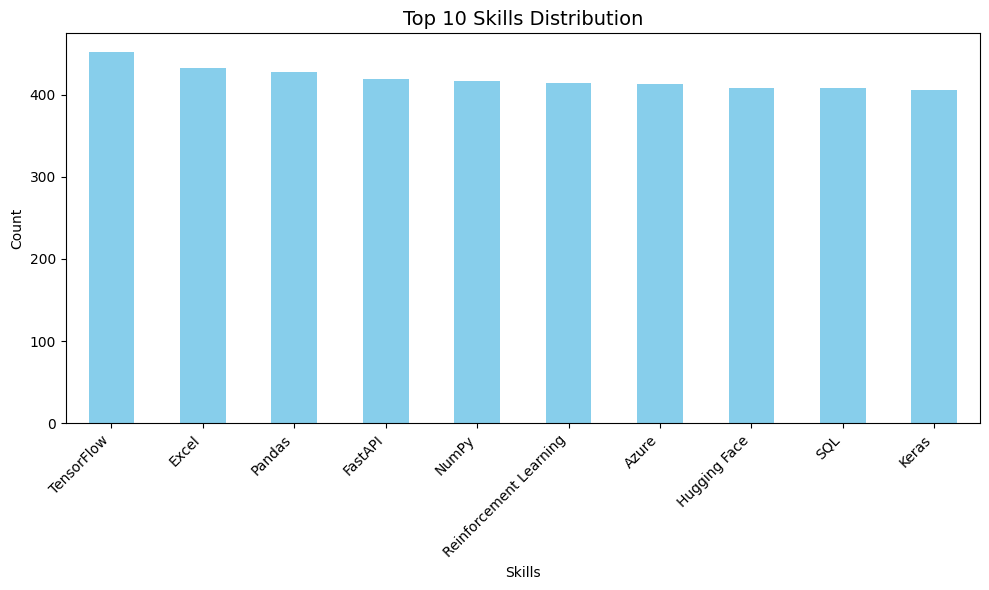

In [ ]:
# Define the file path to the cleaned CSV dataset
file_path = "../dataset/ai_job_market_cleaned.csv"

# Load the CSV file into a pandas DataFrame
data = pd.read_csv(file_path)

# Extract the 'skills_required' column, drop missing values, 
# split comma-separated skills into lists, explode into separate rows,
# and remove extra whitespace
skills = data['skills_required'].dropna().str.split(',').explode().str.strip()

# Count the frequency of each skill and select the top 10 most common
skill_counts = skills.value_counts().head(10)

# Plot the top 10 skills as a bar chart
plt.figure(figsize=(10,6))
skill_counts.plot(kind="bar", color="skyblue")
plt.title("Top 10 Skills Distribution", fontsize=14)  # Chart title
plt.ylabel("Count")  # Y-axis label
plt.xlabel("Skills")  # X-axis label
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to avoid overlap
plt.savefig(os.path.join(output_dir, "top_10_skills_distribution.png"), dpi=300, bbox_inches='tight')
plt.close()
print(f"Saved: {os.path.join(output_dir, 'top_10_skills_distribution.png')}")

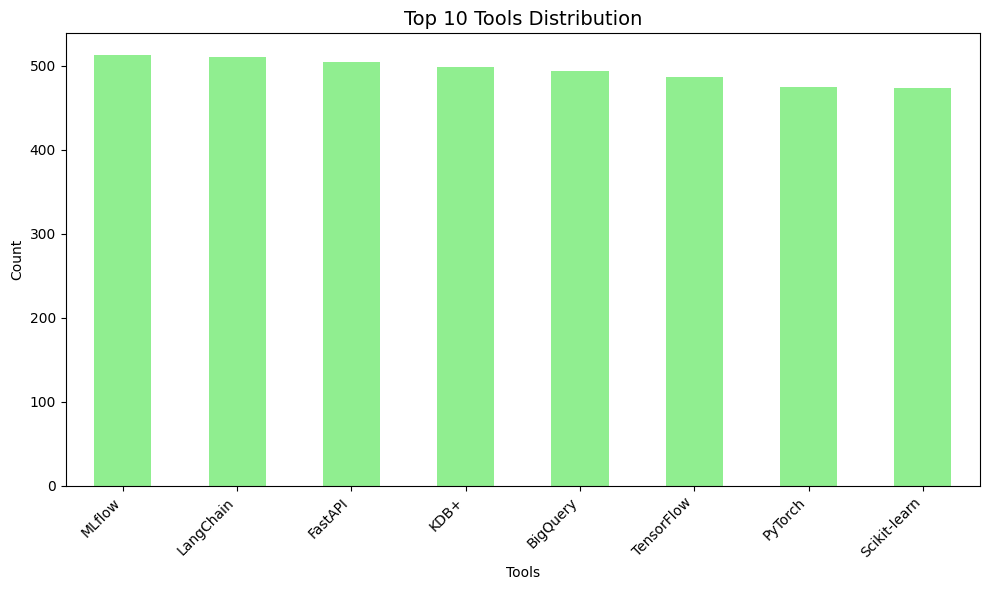

In [ ]:
# Define the file path to the cleaned CSV dataset
file_path = "../dataset/ai_job_market_cleaned.csv"

# Load the CSV file into a pandas DataFrame
data = pd.read_csv(file_path)

# Extract the 'tools_preferred' column, drop missing values,
# split comma-separated tool names into lists, 
# expand lists into separate rows (explode), and strip extra whitespace
tools = data['tools_preferred'].dropna().str.split(',').explode().str.strip()

# Count the frequency of each tool and select the top 10 most common
tool_counts = tools.value_counts().head(10)

# Plot the top 10 tools as a bar chart
plt.figure(figsize=(10,6))
tool_counts.plot(kind="bar", color="lightgreen")
plt.title("Top 10 Tools Distribution", fontsize=14)  # Chart title
plt.ylabel("Count")  # Y-axis label
plt.xlabel("Tools")  # X-axis label
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to avoid overlap
plt.savefig(os.path.join(output_dir, "top_10_tools_distribution.png"), dpi=300, bbox_inches='tight')
plt.close()
print(f"Saved: {os.path.join(output_dir, 'top_10_tools_distribution.png')}")

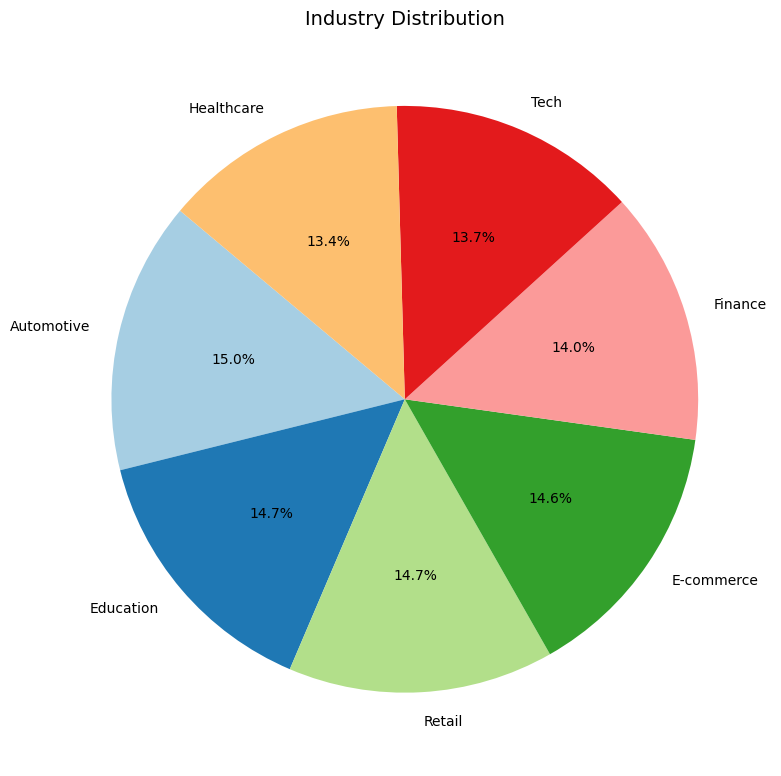

In [ ]:
# Define the file path to the cleaned CSV dataset
file_path = "../dataset/ai_job_market_cleaned.csv"

# Load the CSV file into a pandas DataFrame
data = pd.read_csv(file_path)

# Count the frequency of values in the 'industry' column
# Select the top 8 industries with the highest counts
industry_counts = data['industry'].value_counts().head(8)

# Plot the top 8 industries as a pie chart
plt.figure(figsize=(8,8))
industry_counts.plot(
    kind="pie",                      # Pie chart
    autopct="%1.1f%%",               # Show percentages with 1 decimal place
    startangle=140,                  # Rotate start angle for better visualization
    colors=plt.cm.Paired.colors      # Use a paired color palette
)
plt.title("Industry Distribution", fontsize=14)  # Chart title
plt.ylabel("")  # Remove y-axis label for a cleaner look
plt.tight_layout()  # Adjust layout to prevent overlap
plt.savefig(os.path.join(output_dir, "industry_distribution.png"), dpi=300, bbox_inches='tight')
plt.close()
print(f"Saved: {os.path.join(output_dir, 'industry_distribution.png')}")

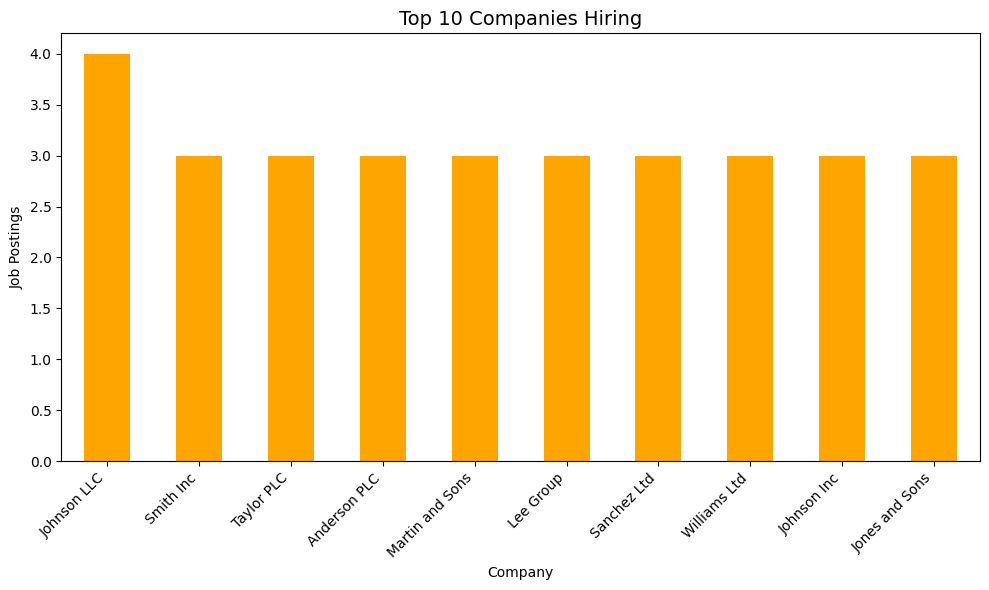

In [ ]:
# Define the file path to the cleaned CSV dataset
file_path = "../dataset/ai_job_market_cleaned.csv"

# Load the CSV file into a pandas DataFrame
data = pd.read_csv(file_path)

# Count the number of job postings per company
# Select the top 10 companies with the most postings
company_counts = data['company_name'].value_counts().head(10)

# Plot the top 10 companies as a bar chart
plt.figure(figsize=(10,6))
company_counts.plot(kind="bar", color="orange")
plt.title("Top 10 Companies Hiring", fontsize=14)  # Chart title
plt.ylabel("Job Postings")  # Y-axis label
plt.xlabel("Company")       # X-axis label
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent label overlap
plt.savefig(os.path.join(output_dir, "top_10_companies_hiring.png"), dpi=300, bbox_inches='tight')
plt.close()
print(f"Saved: {os.path.join(output_dir, 'top_10_companies_hiring.png')}")